In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt              # Visualization
import folium                                # Map
from folium.plugins import MarkerCluster     # Map
from geographiclib.geodesic import Geodesic  # Map
import time, datetime                        # time data
import calendar
import scipy

In [2]:
df = pd.read_csv('train.csv')
df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
df.info()

In [ ]:
df.describe()

In [3]:
# Pickup/Dropoff_Datetime Datatype 변경

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null datetime64[ns]
dropoff_datetime      1458644 non-null datetime64[ns]
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [4]:
# 월, 일, 시간별 데이터 분류
# month
df['month_pickup'] = df.pickup_datetime.dt.month
df['month_dropoff'] = df.dropoff_datetime.dt.month
# day
df['day_pickup'] = df.pickup_datetime.dt.day
df['day_dropoff'] = df.dropoff_datetime.dt.day
# weekday
df['weekday_pickup'] = df.pickup_datetime.dt.weekday
df['weekday_dropoff'] = df.dropoff_datetime.dt.weekday
# day hour
df['hour_pickup'] = df.pickup_datetime.dt.hour
df['hour_dropoff'] = df.dropoff_datetime.dt.hour

In [5]:
# Data Sampling
np.random.seed(2018)
df_sample = df.sample(n=1000, replace=True)
df_sample.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month_pickup,month_dropoff,day_pickup,day_dropoff,weekday_pickup,weekday_dropoff,hour_pickup,hour_dropoff
107770,id2426300,1,2016-04-29 23:00:58,2016-04-29 23:18:35,2,-73.982101,40.773357,-73.980255,40.743099,N,1057,4,4,29,29,4,4,23,23
846438,id0986187,1,2016-06-13 17:13:29,2016-06-13 17:22:52,1,-73.964043,40.773533,-73.980896,40.773445,N,563,6,6,13,13,0,0,17,17
1390818,id1447713,1,2016-06-07 10:14:07,2016-06-07 10:51:31,1,-73.781815,40.644627,-73.793465,40.657291,N,2244,6,6,7,7,1,1,10,10
609033,id1296571,1,2016-05-01 15:22:50,2016-05-01 15:27:08,2,-73.974243,40.753857,-73.981712,40.756279,N,258,5,5,1,1,6,6,15,15
1164181,id3437685,1,2016-02-26 14:28:27,2016-02-26 14:35:16,1,-73.978989,40.736385,-73.966347,40.754875,N,409,2,2,26,26,4,4,14,14


In [6]:
# 지도상에 샘플링 데이터 위치정보 표시 & 지역별 데이터 수 
m = folium.Map(
    location=[np.mean(df['pickup_latitude']), np.mean(df['pickup_longitude'])],
    zoom_start=10)

marker_cluster = MarkerCluster(
    name='1000 clustered icons',
    overlay=True,
    control=False,
    icon_create_function=None
)

for i in range(len(df_sample)):
    location=[df_sample.iloc[i, 6], df_sample.iloc[i, 5]]
    folium.CircleMarker(
        location=location,
        radius=1,
        color = "blue"
      ).add_to(m)
    marker = folium.Marker(location=location)
    marker_cluster.add_child(marker)
    marker_cluster.add_to(m)
    
m

샘플링 후 위치정보를 확인해보면 대부분의 위치정보가 Mahattan에 위치해 있으며, 
그외에 특이지역은 LaGuardia Airport와 JFK Airport로 나타난다.

## 1. Single Feature

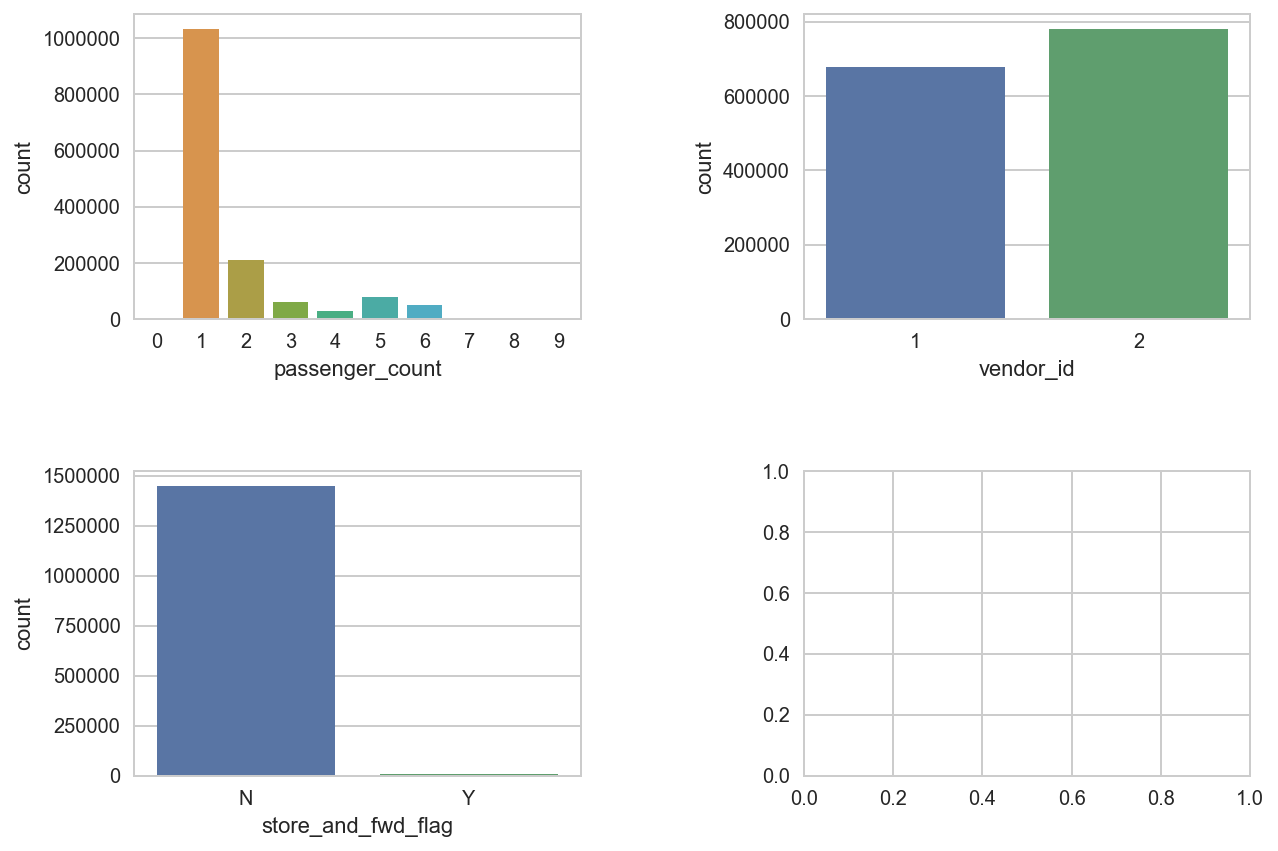

In [7]:
fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

ax1 = fig.add_subplot(221)
data1 = df.groupby('passenger_count').aggregate({'id':'count'}).reset_index()
sns.barplot(x='passenger_count', y='id', data=data1, ax=ax1)
plt.ylabel('count')

ax2 = fig.add_subplot(222)
data2 = df.groupby('vendor_id').aggregate({'id':'count'}).reset_index()
sns.barplot(x='vendor_id', y='id', data=data2, ax=ax2)
plt.ylabel('count')

ax3 = fig.add_subplot(223)
data3 = df.groupby('store_and_fwd_flag').aggregate({'id':'count'}).reset_index()
sns.barplot(x='store_and_fwd_flag', y='id', data=data3, ax=ax3)
plt.ylabel('count')

ax4 = fig.add_subplot(224)


plt.show()

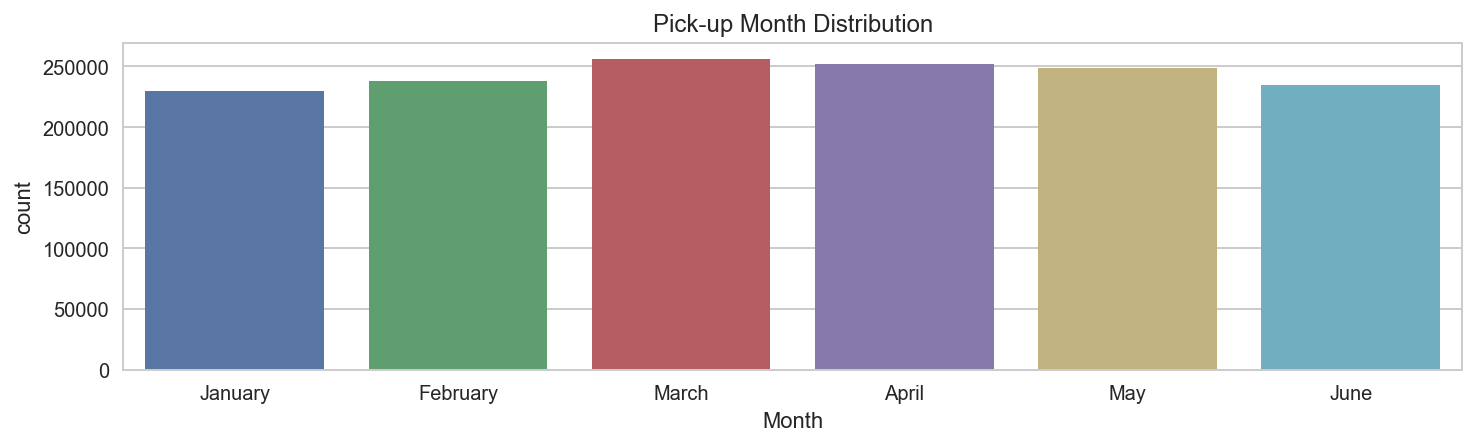

In [8]:
# 월별 Pick-up Distribution
plt.figure(figsize=(12,3))

data = df.groupby('month_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='month_pickup', y='id', data=data)


plt.title('Pick-up Month Distribution')
plt.xlabel('Month')
plt.xticks(range(0,6), calendar.month_name[1:7])
plt.ylabel('count')

plt.show()

- 1월과 2월 그리고 6월 상대적으로 이용횟수가 적은것을 볼 수 있습니다.

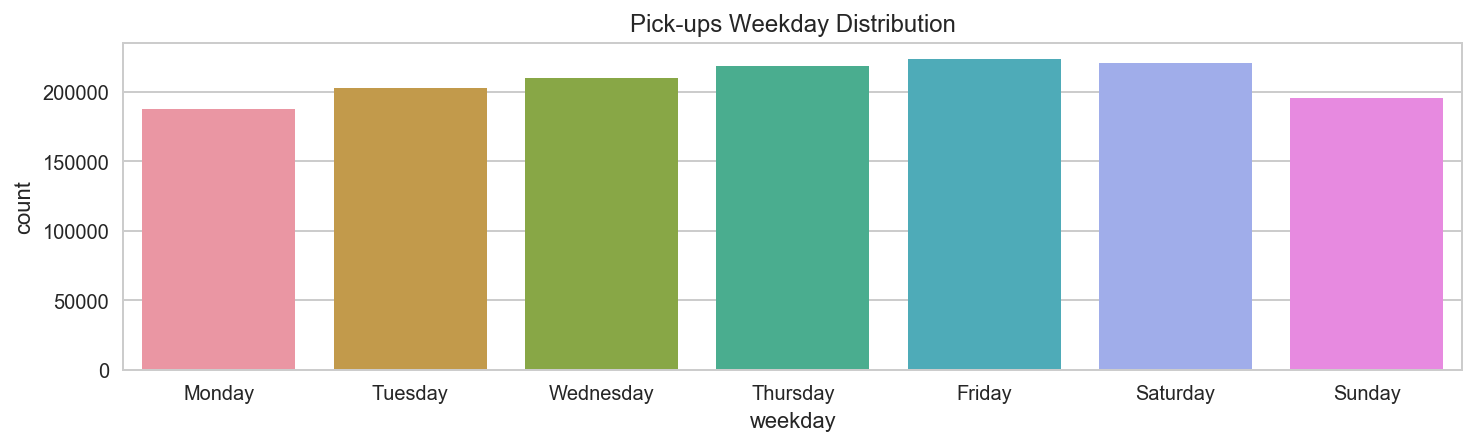

In [9]:
# 요일별 Pick-up Distribution
plt.figure(figsize=(12,3))

data = df.groupby('weekday_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='weekday_pickup', y='id', data=data)


plt.title('Pick-ups Weekday Distribution')
plt.xlabel('weekday')
plt.xticks(range(0,7), calendar.day_name[0:7])
plt.ylabel('count')

plt.show()

- 월요일이 가장 적은 분포를 보여주고 있으며
- 금요일에 가장 높은 분포를 보여주고 있습니다.

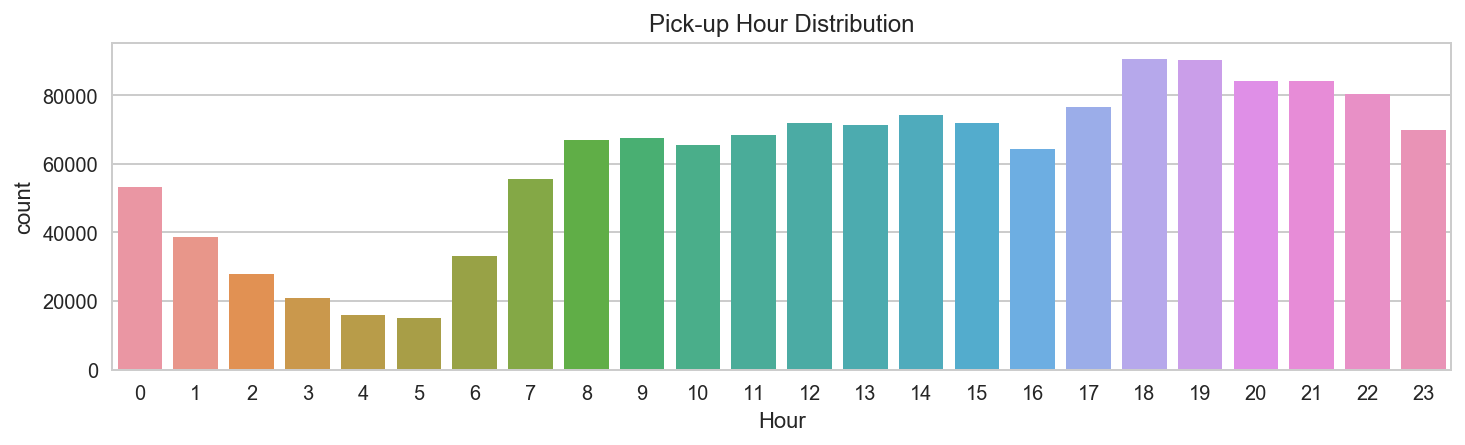

In [10]:
# 시간대별 Pick-up Distribution
plt.figure(figsize=(12,3))

data = df.groupby('hour_pickup').aggregate({'id':'count'}).reset_index()
sns.barplot(x='hour_pickup', y='id', data=data)

plt.title('Pick-up Hour Distribution')
plt.xlabel('Hour')
plt.ylabel('count')

plt.show()

- 시간대별 Pick-up 분포를 살펴보면
  - 18시~19시에 많은 높은 분포를 차지하고 있으며
  - 새벽시간(1시~6시)에 가장 낮은 분포를 보여주고 있습니다.
  - 새벽시간 이후에는 16시에 상대적으로 낮은 분포를 보이고 있습니다.

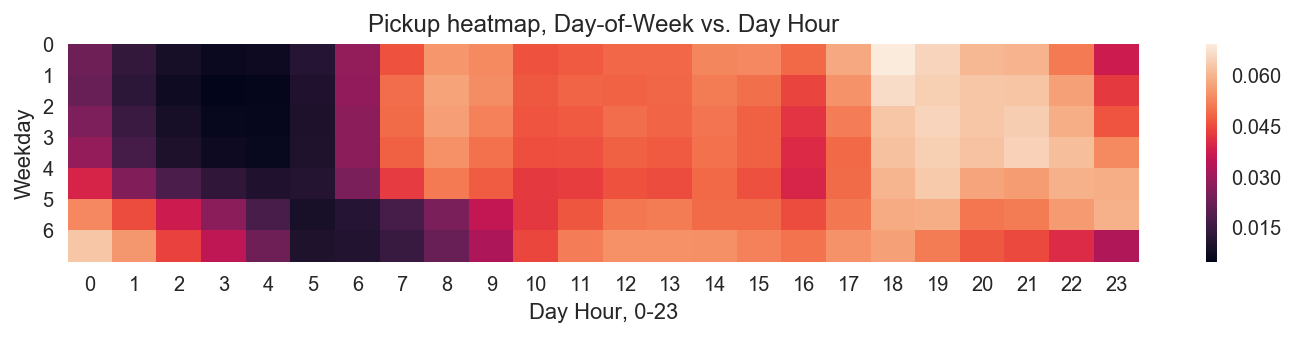

In [11]:
plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df.weekday_pickup, 
                             df.hour_pickup, 
                             values=df.id, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), rotation='horizontal')

plt.show()

### Distance 구하기

In [12]:
from math import sin, cos, sqrt, atan2, radians

# approximate radius of earth in km
R = 6371.0

dis = []

for i in range(len(df)):
    lat1 = radians(float(df.iloc[i,6]))
    lon1 = radians(float(df.iloc[i,5]))
    lat2 = radians(float(df.iloc[i,8]))
    lon2 = radians(float(df.iloc[i,7]))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    dis.append(distance)
    
df['distance'] = dis

df.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month_pickup,month_dropoff,day_pickup,day_dropoff,weekday_pickup,weekday_dropoff,hour_pickup,hour_dropoff,distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,3,14,14,0,0,17,17,1.498521
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,12,12,6,6,0,0,1.805507
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,19,19,1,1,11,12,6.385098
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,4,6,6,2,2,19,19,1.485498
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,3,26,26,5,5,13,13,1.188588


## 2. Feature Relations

### 2.1 Pickup date & trip_duration

In [14]:
taxi_weekday = pd.DataFrame(df, columns=['vendor_id', 'weekday_pickup','trip_duration'])
taxi_weekday1 = taxi_weekday.groupby(['vendor_id', 'weekday_pickup']).agg('median').reset_index() 

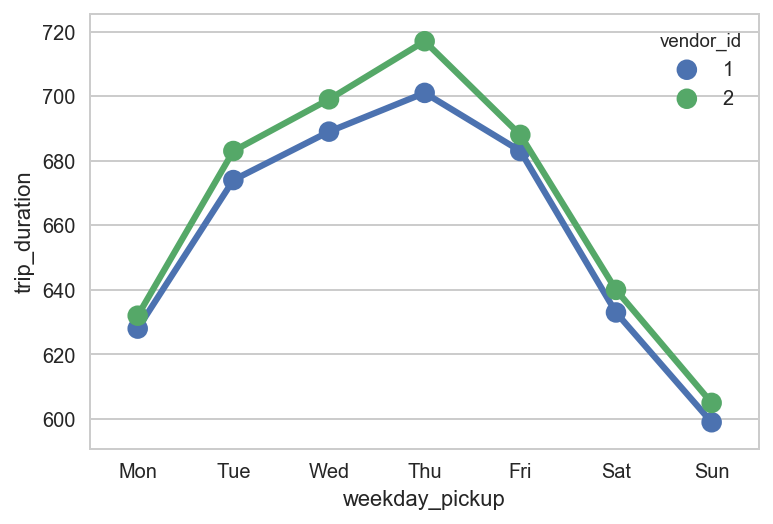

In [15]:
sns.pointplot(x=taxi_weekday1['weekday_pickup'], y=taxi_weekday1['trip_duration'], hue = taxi_weekday1['vendor_id'], data=taxi_weekday1)
plt.xticks(range(0,7), ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'))

plt.show()

In [16]:
taxi_weekday2 = pd.DataFrame(df, columns=['vendor_id', 'hour_pickup','trip_duration'])
taxi_weekday3 = taxi_weekday2.groupby(['vendor_id', 'hour_pickup']).agg('median').reset_index()

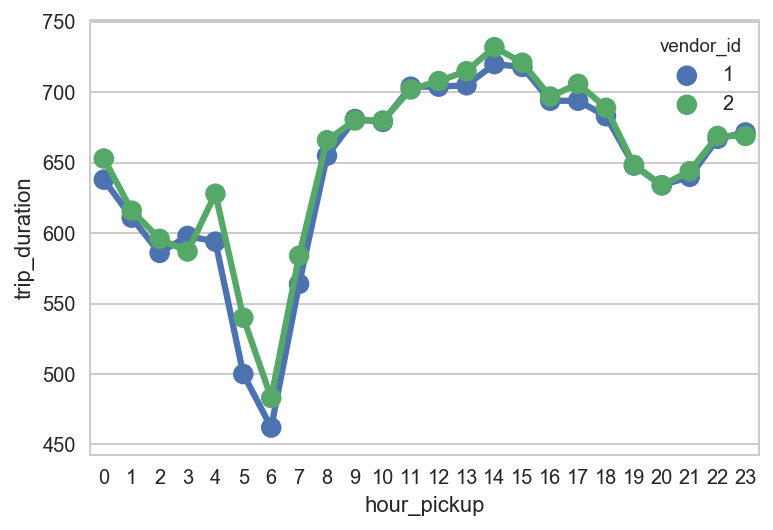

In [17]:
sns.pointplot(x=taxi_weekday3['hour_pickup'], y=taxi_weekday3['trip_duration'], hue = taxi_weekday3['vendor_id'], data=taxi_weekday3)

plt.show()

### 2.2 Passenger count & trip_duration

In [ ]:
plt.figure(figsize=(12, 5))
df_passenger = df['trip_duration'].groupby(df['passenger_count'])
sns.boxplot(x="passenger_count", y="trip_duration", data=df, dodge=False).set_yscale('log')
plt.show()

## 3. Data Cleaning

### 3.1 Passenger counter가 0 데이터

In [18]:
df_passenger0 = df.loc[df.passenger_count == 0]
df_passenger0['trip_duration'].describe()

count       60.000000
mean      1718.433333
std      11072.157098
min          1.000000
25%          6.750000
50%         20.500000
75%         92.250000
max      85901.000000
Name: trip_duration, dtype: float64

In [19]:
df_passenger0['distance'].describe()

count    60.000000
mean      1.246954
std       3.520002
min       0.000000
25%       0.001426
50%       0.007287
75%       0.137650
max      19.013222
Name: distance, dtype: float64

## 이건 그냥

승객 수가 0명인 데이터를 확인해보면,
trip duration은 75%수준이 92초정도이며,
distance는 75%수준이 0.13km으로

시간(초)과 거리가 Trip을 했다고 볼 수 없는 상황이다.

In [ ]:
df_passenger0[df_passenger0['trip_duration'] > 92]

In [ ]:
df_passenger0[df_passenger0['distance'] > 0.137650]

### 3.2 Trip_duration 

1일은 86,400초

Trip duration이 $ 10^5 $ 이상인 데이터는 24시간 이상이 소요된 Trip이 된다.


### 3.2. 1) 24시간 이상 걸린 Trip Duration

- 위도/경도 정보를 확인해서 실제로 장거리 여행이였는지 확인
- 그것이 아니라면 Outlier로 판단할 수 있다.

In [20]:
df[df['trip_duration'] > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month_pickup,month_dropoff,day_pickup,day_dropoff,weekday_pickup,weekday_dropoff,hour_pickup,hour_dropoff,distance
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736,1,1,5,27,1,2,0,11,20.148664
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578,2,3,13,8,5,1,22,15,5.982487
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612,1,1,5,31,1,6,6,1,1.635128
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282,2,3,13,25,5,4,22,18,19.900661


Passenger count vs trip_duration 그래프에서 볼 수 있는
Passenger 1의 3개와 passenger 2의 1개 데이터가 1일 이상의 시간소요를 보여준 여행이다.

시간소요 대비 거리는 20km, 5km, 1.6km, 19km로 4개의 데이터는 합리적이지 않은 데이터로 Outlier로 판단

### 3.2.  2) 1분보다 짧게 걸린 Trip Duration

In [21]:
print(len(df[df['trip_duration'] < 60]))
df1 = df[df['trip_duration'] < 60]

8595


In [22]:
print(len(df1[df1['distance'] == 0]))
df1[df1['distance'] == 0]

1675


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month_pickup,month_dropoff,day_pickup,day_dropoff,weekday_pickup,weekday_dropoff,hour_pickup,hour_dropoff,distance
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,1,1,27,27,2,2,22,22,0.0
1728,id2134482,1,2016-01-22 16:13:01,2016-01-22 16:13:20,1,-73.776314,40.645454,-73.776314,40.645454,N,19,1,1,22,22,4,4,16,16,0.0
2441,id2251007,2,2016-05-23 14:20:49,2016-05-23 14:20:57,1,-73.781830,40.644699,-73.781830,40.644699,N,8,5,5,23,23,0,0,14,14,0.0
2625,id3885040,1,2016-04-18 12:55:14,2016-04-18 12:55:20,1,-73.788239,40.641476,-73.788239,40.641476,N,6,4,4,18,18,0,0,12,12,0.0
3042,id2206138,1,2016-01-21 12:07:45,2016-01-21 12:07:51,1,-73.782715,40.643967,-73.782715,40.643967,N,6,1,1,21,21,3,3,12,12,0.0
3261,id1606138,2,2016-04-27 15:14:54,2016-04-27 15:15:01,2,-74.177780,40.690281,-74.177780,40.690281,N,7,4,4,27,27,2,2,15,15,0.0
4158,id3695064,1,2016-04-11 15:30:02,2016-04-11 15:30:19,1,-73.794067,40.657173,-73.794067,40.657173,N,17,4,4,11,11,0,0,15,15,0.0
4892,id0915475,1,2016-03-14 06:03:38,2016-03-14 06:03:43,1,-73.982407,40.731144,-73.982407,40.731144,N,5,3,3,14,14,0,0,6,6,0.0
7794,id0688948,1,2016-04-14 20:13:28,2016-04-14 20:13:43,1,-74.161804,40.836494,-74.161804,40.836494,N,15,4,4,14,14,3,3,20,20,0.0
8618,id1855512,2,2016-01-29 02:40:15,2016-01-29 02:40:25,1,-73.959122,40.712090,-73.959122,40.712090,N,10,1,1,29,29,4,4,2,2,0.0


Trip Duration이 1분 이하이고, Distance 또한 0인 데이터는 1675개이다.

이 데이터들은 분석적으로 합당한 데이터로 보이지 않으며, 제거하는 것이 합리적인 것 같다.

### 3.3  Zero-Distance

In [23]:
df['distance'].describe()

count    1.458644e+06
mean     3.440864e+00
std      4.296538e+00
min      0.000000e+00
25%      1.231837e+00
50%      2.093717e+00
75%      3.875337e+00
max      1.240909e+03
Name: distance, dtype: float64

In [24]:
print(len(df[df['distance'] == 0]))
df[df['distance'] == 0].head(10)

5897


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month_pickup,month_dropoff,day_pickup,day_dropoff,weekday_pickup,weekday_dropoff,hour_pickup,hour_dropoff,distance
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.981819,40.768963,-73.981819,40.768963,N,227,2,2,29,29,0,0,18,18,0.0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.959068,40.775661,-73.959068,40.775661,N,1109,5,5,10,10,1,1,18,18,0.0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.808487,40.687336,-73.808487,40.687336,N,947,5,5,16,16,0,0,23,23,0.0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.786720,40.647041,-73.786720,40.647041,N,580,1,1,25,25,0,0,19,19,0.0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.209854,40.816853,-74.209854,40.816853,N,27,1,1,27,27,2,2,22,22,0.0
1728,id2134482,1,2016-01-22 16:13:01,2016-01-22 16:13:20,1,-73.776314,40.645454,-73.776314,40.645454,N,19,1,1,22,22,4,4,16,16,0.0
1769,id2892749,1,2016-01-18 15:24:43,2016-01-18 15:28:57,5,-73.954666,40.821003,-73.954666,40.821003,Y,254,1,1,18,18,0,0,15,15,0.0
2087,id0931199,2,2016-05-04 22:28:43,2016-05-04 22:32:51,1,-73.954628,40.777180,-73.954628,40.777180,N,248,5,5,4,4,2,2,22,22,0.0
2441,id2251007,2,2016-05-23 14:20:49,2016-05-23 14:20:57,1,-73.781830,40.644699,-73.781830,40.644699,N,8,5,5,23,23,0,0,14,14,0.0
2609,id1992673,2,2016-03-02 20:10:41,2016-03-02 20:30:53,5,-73.875313,40.773682,-73.875313,40.773682,N,1212,3,3,2,2,2,2,20,20,0.0


Distance가 0인 데이터는 총 5,897개이며,

Trip Duration이 1분 이상인 데이터는 4,222개 데이터를 어떻게 판단할지 논의할 필요가 있을 것 같다.